<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/11-Classifica%C3%A7%C3%A3o_D%C3%ADgitos_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import joblib
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

sklearn: 1.2.2
tensorflow: 2.13.0


In [4]:
!pip install scikeras
import scikeras
import scikeras.wrappers

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

print ( gpus )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
train_model = True
run_grid_search = True
save_model = True

model_path = ""
scaler_path = ""
if not train_model:
    model_path = "keras_model.h5"
    # model_path = "models/ANN/keras_model.h5"
    scaler_path = "standard_scaler.joblib"
    # scaler_path = "models/ANN/standard_scaler.joblib"

### Amostra de dígitos

In [7]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:50000])]))[:, 1]
    reorder_valid = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[50000:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:50000] = mnist.data[reorder_train]
    mnist.target[:50000] = mnist.target[reorder_train]
    mnist.data[50000:60000] = mnist.data[reorder_valid + 50000]
    mnist.target[50000:60000] = mnist.target[reorder_valid + 50000]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
X_train_raw = mnist.data[:50000]
y_train = mnist.target[:50000]
X_valid_raw = mnist.data[50000:60000]
y_valid = mnist.target[50000:60000]
X_test_raw = mnist.data[60000:]
y_test = mnist.target[60000:]

print ( X_train_raw.shape )
print ( X_valid_raw.shape )
print ( X_test_raw.shape )

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(50000, 784)
(10000, 784)
(10000, 784)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = None
X_train = None
if train_model:
    scaler = StandardScaler()
    X_train = scaler.fit_transform( X_train_raw )
else:
    scaler = load( scaler_path )
    X_train = scaler.transform( X_train_raw )
X_valid = scaler.transform( X_valid_raw )
X_test  = scaler.transform( X_test_raw )

print ( scaler )

if train_model and save_model:
    dump( scaler, "standard_scaler.joblib")
    # dump( scaler, "models/standard_scaler.joblib")

StandardScaler()


9
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00483977 -0.00630411 -0.00447218 -0.00447218  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00447218 -0.00515922 -0.00963928 -0.01211949
 -0.01436819 -0.01737385 -0.02270852 -0.02757692 -0.02980096 -0.03081968
 -0.03110097 -0.03015775 -0.03021858 -0.02670023 -0.02103146 -0.01838468
 -0.0166327  -0.01131016 -0.00800445 -0.00479882  0.          0.
  0.          0.          0.          0.         -0.00447218 -0.00447218
 -0.00889745 -0.01236598 -0.01790015 -0.02738895 -0.0371536  -0.05175937
 -0.06602942 -0.082747   -0.10052937 -0.11606085 -0.12843945 -0.13638324
 -0.13592586 -0.1297393  -0.11885722 -0.10081914 -0.07808218 -0.05640676
 -0.03917999 -0.02442581 -0.01543332 -0.00857831  0.          0.
  0.          0.         -0.0048

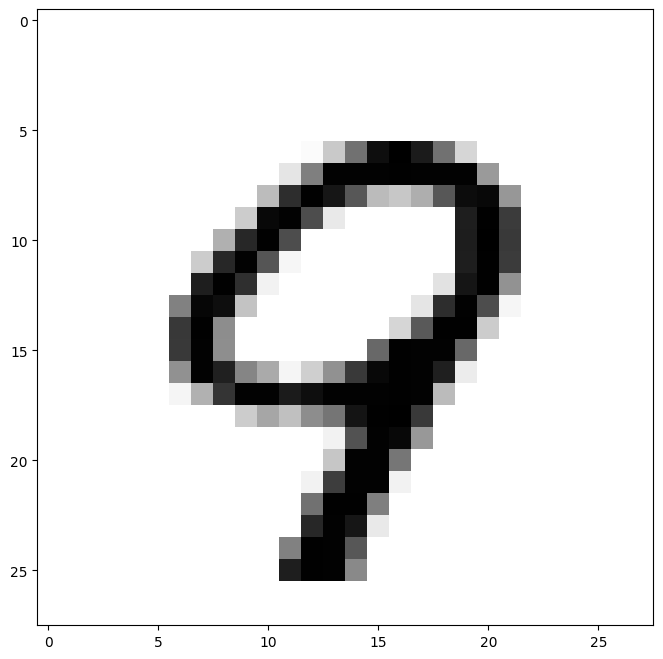

In [9]:
idx = 9900
print ( y_valid[ idx ] )
print ( X_valid[ idx ] )

fig = plt.figure( figsize=(4,4) )
plt.imshow( X_valid_raw[ idx ].reshape(28,28), cmap='binary' )

### Treinamento

In [10]:
shuffle_index = np.random.permutation( 50000 )
X_train_shuffle, y_train_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ]

### Definição do modelo

In [11]:
class Model:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def __call__(self, n_hidden, n_neurons, dropout):

        input_shape = self.input_shape
        learning_rate = self.learning_rate

        print( "Building model with:" )
        print( "Input shape: {}".format(input_shape) )
        print( "Learning rate: {}".format(learning_rate) )
        print( "Number of hidden layers: {}".format(n_hidden) )
        print( "Number of neurons per layer: {}".format(n_neurons) )
        print( "Dropout rate: {}".format(dropout) )

        model = keras.models.Sequential()
        model.add( keras.layers.InputLayer(input_shape=input_shape) )
        for layer in range(n_hidden):
            if dropout > 0.:
                model.add( keras.layers.Dropout(rate=dropout) )
            model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )
        model.add( keras.layers.Dense(10, activation="softmax") )

        #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
        model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

        return model

def build_model(input_shape, learning_rate=5e-4, n_hidden=1, n_neurons=50, dropout=0.20 ):
    build_fn_ = Model( input_shape=input_shape, learning_rate=learning_rate )
    return build_fn_( n_hidden, n_neurons, dropout )


### Callbacks

In [12]:
import os

def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

def callbacks(patience=5, lr_scheduler_fn=None, log_dir=None):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )

    # Learning rate exponential decay
    if lr_scheduler_fn:
        lr_scheduler_cb_ = keras.callbacks.LearningRateScheduler( lr_scheduler_fn )
        callbacks_.append( lr_scheduler_cb_ )

    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )

    return callbacks_


### Learning rate scan

In [13]:
def find_max_learning_rate( X, y, X_val, y_val, lr_init=1e-4, lr_end=5e-2, steps=20, epochs=20, model_build_fn=build_model, callback_fn=callbacks, *build_fn_args, **build_fn_kwargs ):
    results_ = {}
    results_['learning_rate'] = []
    results_['loss'] = []
    results_['accuracy'] = []
    results_['val_loss'] = []
    results_['val_accuracy'] = []
    c_ = (lr_end/lr_init) ** (1/steps)
    lr_ = lr_init
    for i_it in range( steps + 1 ):
        results_['learning_rate'].append( lr_ )
        model_ = model_build_fn( *build_fn_args, **build_fn_kwargs, learning_rate=lr_ )
        callbacks_ = callback_fn(patience=5)
        history_ = model_.fit( X, y, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks_ )
        results_['loss'].append( history_.history['loss'] )
        results_['accuracy'].append( history_.history['accuracy'] )
        results_['val_loss'].append( history_.history['val_loss'] )
        results_['val_accuracy'].append( history_.history['val_accuracy'] )
        # Update learning rate
        lr_ = lr_ * c_

    return results_

In [14]:
learning_rate_scan = True
epochs_lr_scan = 20
results = None
if learning_rate_scan:
    results = find_max_learning_rate(
                X_train_shuffle, y_train_shuffle,
                X_valid, y_valid,
                lr_init=1e-4,
                lr_end=2e-2,
                steps=5,
                epochs=epochs_lr_scan,
                model_build_fn=build_model,
                input_shape=X_train_shuffle.shape[1:],
                n_hidden=2,
                n_neurons=20,
                dropout=0.,
                )

Building model with:
Input shape: (784,)
Learning rate: 0.0001
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.0
Epoch 1/20
1563/1563 [==============================] - 20s 7ms/step - loss: 1.0300 - accuracy: 0.7074 - val_loss: 0.4887 - val_accuracy: 0.8770
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4299 - accuracy: 0.8850 - val_loss: 0.3395 - val_accuracy: 0.9078
Epoch 3/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3269 - accuracy: 0.9084 - val_loss: 0.2885 - val_accuracy: 0.9219
Epoch 4/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2791 - accuracy: 0.9200 - val_loss: 0.2620 - val_accuracy: 0.9297
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2491 - accuracy: 0.9280 - val_loss: 0.2443 - val_accuracy: 0.9334
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2279 - accuracy: 0.9337 - val_loss: 0.2314 - val_accuracy: 0

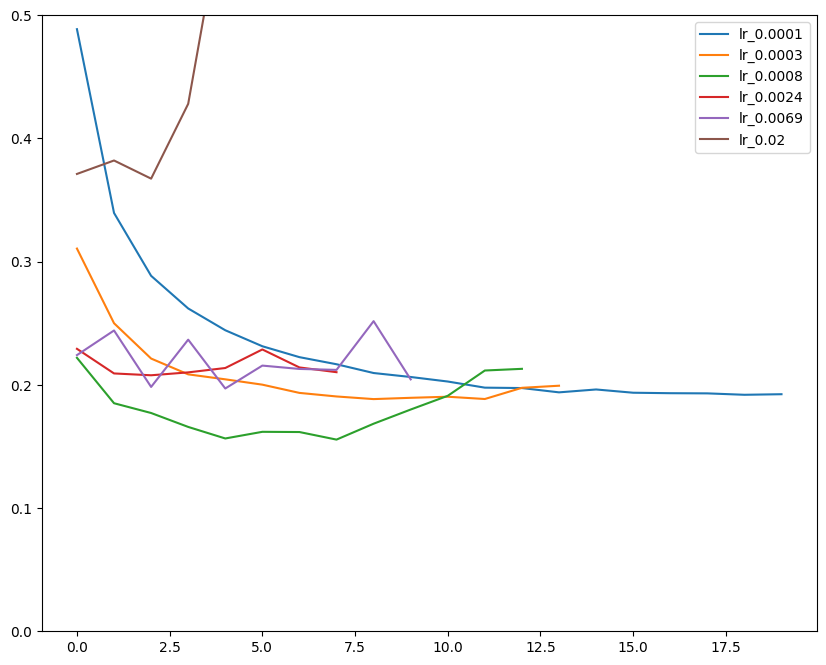

In [15]:
if learning_rate_scan:
    # metrics_ = 'loss'
    metrics_ = 'val_loss'
    # metrics_ = 'val_accuracy'
    columns_=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)]
    df_ = pd.DataFrame( np.full((epochs_lr_scan,len(columns_)),np.nan), columns=columns_ )
    fig_ = plt.figure( figsize=(10,8) )
    for i_lr_,col_ in enumerate(columns_):
        df_[col_] = pd.Series( results[ metrics_ ][i_lr_] )
        df_[col_].plot()
    plt.legend()
    # plt.yscale('log')
    plt.ylim( 0., 0.50 )
    # plt.ylim( 0.80, 1.05 )

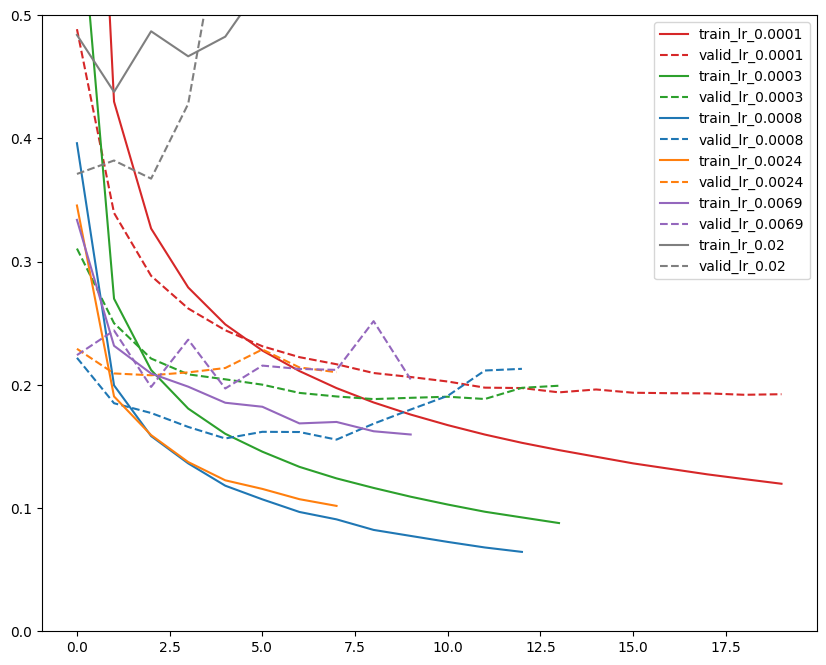

In [16]:
if learning_rate_scan:
    metrics_train_ = 'loss'
    metrics_valid_ = 'val_loss'
    colors_=['tab:red','tab:green','tab:blue','tab:orange', 'tab:purple', 'tab:gray']
    columns_=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)]
    df_ = pd.DataFrame( np.full((epochs_lr_scan,2*len(columns_)),np.nan), columns=( 2 * columns_ ) )
    fig_ = plt.figure( figsize=(10,8) )
    for i_lr_,col_ in enumerate(columns_):
        df_[ "train_{}".format( col_ ) ] = pd.Series( results[ metrics_train_ ][i_lr_] )
        df_[ "train_{}".format( col_ ) ].plot( color=colors_[ i_lr_ % len(colors_) ] )
        df_[ "valid_{}".format( col_ ) ] = pd.Series( results[ metrics_valid_ ][i_lr_] )
        df_[ "valid_{}".format( col_ ) ].plot( color=colors_[ i_lr_ % len(colors_) ], linestyle='dashed' )
    plt.legend()
    # plt.yscale('log')
    plt.ylim( 0., 0.50 )

#### Exponential learning rate scheduling

In [17]:
class ExponentialDecayLR:
    def __init__( self, lr0, s ):
        self.lr0 = lr0
        self.s = s
    def __call__( self, epoch ):
        return self.lr0 * 0.1**( epoch / self.s )

(1e-05, 0.02)

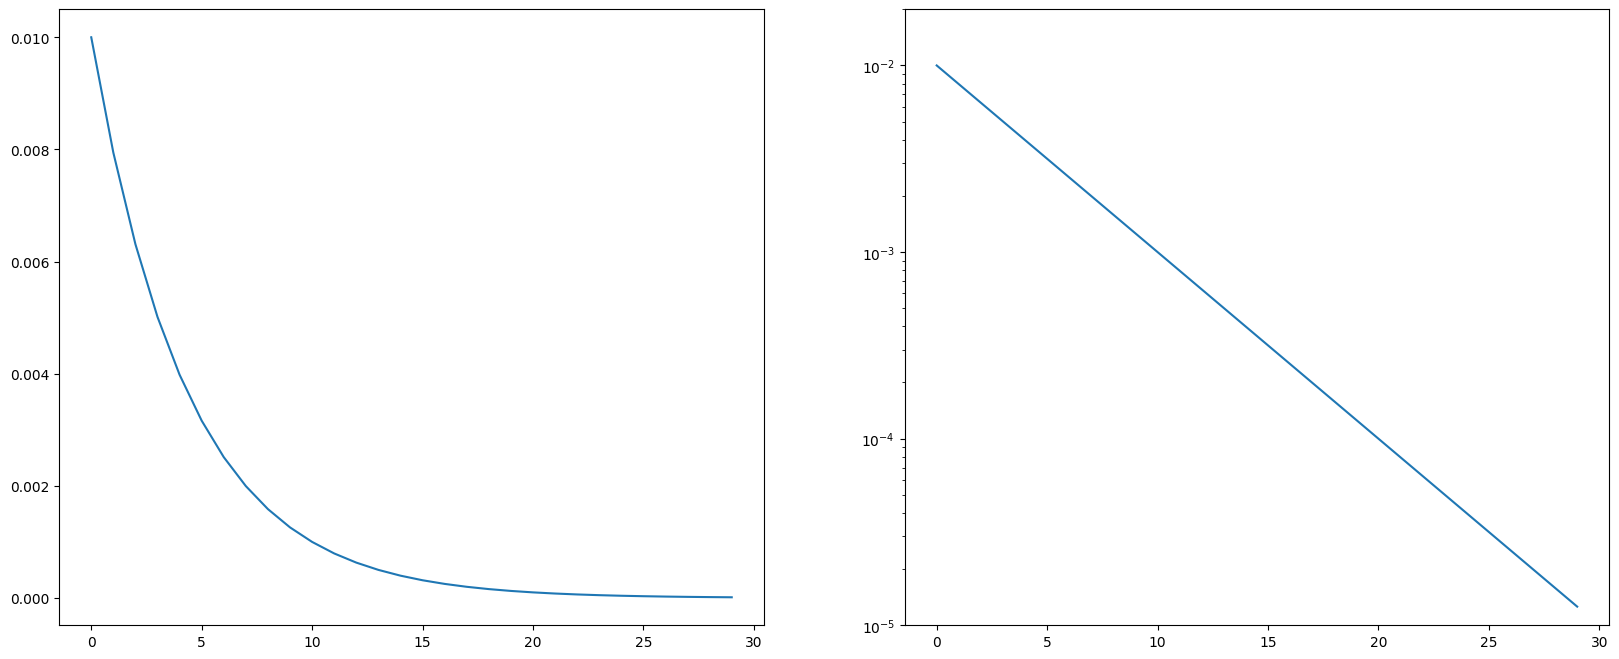

In [18]:
exponential_decay_ = ExponentialDecayLR( lr0=1e-2, s=10 )

fig, axes = plt.subplots( 1, 2, figsize=(20,8) )
xplot__ = np.arange(30)
axes[0].plot( xplot__, exponential_decay_( xplot__ ) )
axes[1].plot( xplot__, exponential_decay_( xplot__ ) )
axes[1].set_yscale( 'log' )
axes[1].set_ylim( 1e-5, 2e-2 )

In [19]:
model = build_model(
    input_shape=X_train_shuffle.shape[1:],
    learning_rate=1e-2,
    n_hidden=2,
    n_neurons=20,
    dropout=0.
    )

callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )
epochs_ = 20
batch_size_ = 32
history = model.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_, batch_size=batch_size_, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.0
Epoch 1/20
1563/1563 [==============================] - 8s 4ms/step - loss: 0.3707 - accuracy: 0.8978 - val_loss: 0.2764 - val_accuracy: 0.9266 - lr: 0.0100
Epoch 2/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2532 - accuracy: 0.9297 - val_loss: 0.2281 - val_accuracy: 0.9370 - lr: 0.0079
Epoch 3/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1985 - accuracy: 0.9438 - val_loss: 0.2304 - val_accuracy: 0.9425 - lr: 0.0063
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1683 - accuracy: 0.9509 - val_loss: 0.1847 - val_accuracy: 0.9531 - lr: 0.0050
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1380 - accuracy: 0.9597 - val_loss: 0.1820 - val_accuracy: 0.9555 - lr: 0.0040
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0

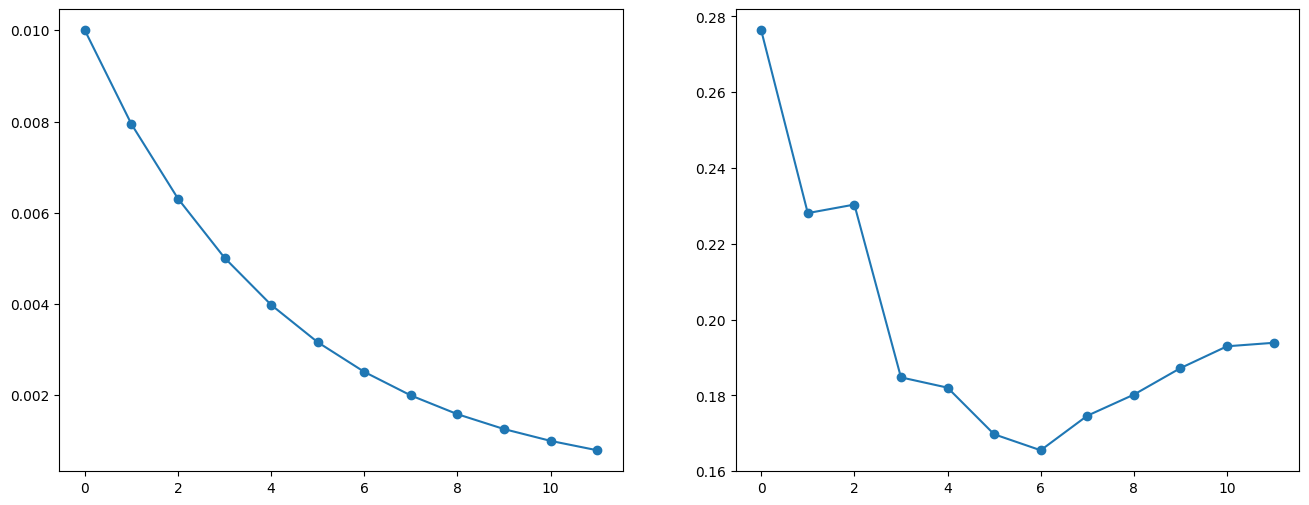

In [20]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['lr'], 'o-' )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-' )

### Hyperparameter scan

In [21]:
# FIXME: update to https://keras.io/keras_tuner/

# learning_rate = 5e-4

n_iter_search = 10
cv = 4
n_jobs = 8
epochs_grid_search = 5
# scoring = 'accuracy'
# scoring = 'f1'

grid_search = None
if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    from sklearn.model_selection import RandomizedSearchCV
    #from sklearn.model_selection import GridSearchCV

    # build_fn_ = Model( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 )
    # keras_clf = keras.wrappers.scikit_learn.KerasClassifier( build_fn_ )

    def model_fn_( n_hidden, n_neurons, dropout ):
        build_fn_ = Model( input_shape=X_train_shuffle.shape[1:], learning_rate=5e-4 )
        return build_fn_( n_hidden, n_neurons, dropout )

    callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )
    print ( callbacks_ )
    params_ = {'n_hidden': 2, 'n_neurons': 50, 'dropout': 0.20, 'batch_size': 32}
    keras_clf = scikeras.wrappers.KerasClassifier( model=model_fn_, **params_, callbacks=callbacks_ )
    print ( keras_clf )

    param_distribs = {
        "n_hidden": np.arange(2,6),
        "n_neurons": 2 ** np.arange(4,8),
        "dropout":  0.1 * np.arange(2,6),
        "batch_size": 2 ** np.arange(5,8)
        }

    grid_search = RandomizedSearchCV(
        keras_clf,
        param_distribs,
        n_iter=n_iter_search, cv=cv, verbose=20, n_jobs=n_jobs, refit=False, random_state=42
        )

    # grid_search.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_grid_search, validation_data=(X_valid, y_valid), callbacks=callbacks_ )
    with joblib.parallel_backend( "threading" ):
        grid_search.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_grid_search, validation_data=(X_valid, y_valid) )

    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2023/10/03 15:47:20
[<keras.src.callbacks.EarlyStopping object at 0x7bea856e2bc0>, <keras.src.callbacks.LearningRateScheduler object at 0x7bea856e33d0>]
KerasClassifier(
	model=<function model_fn_ at 0x7bea8a0a8820>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7bea856e2bc0>, <keras.src.callbacks.LearningRateScheduler object at 0x7bea856e33d0>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	n_hidden=2
	n_neurons=50
	dropout=0.2
	class_weight=None
)
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START batch_size=32, dropout=0.4, n_hidden=5, n_neurons=32.......
[CV 2/4; 1/10] START batch_size=32, dropout=0.4, n_hidden=5, n_neurons=32.......
[CV 3/4; 1/10] START batch_size=32, dropout=0.4, n_hidden=5, n_neurons=32.......
[CV 4/4; 1/10] START batch_size=32, dropout=0.4, n_hidden=5, 

293/293 [==============================] - 35s 65ms/step - loss: 1.1535 - accuracy: 0.6454 - val_loss: 0.3885 - val_accuracy: 0.8893 - lr: 0.0100
Epoch 2/5
293/293 [==============================] - 36s 57ms/step - loss: 1.0163 - accuracy: 0.6847 - val_loss: 0.3634 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 2/5
293/293 [==============================] - 13s 46ms/step - loss: 0.7221 - accuracy: 0.7889 - val_loss: 0.3309 - val_accuracy: 0.9111 - lr: 0.0079
Epoch 3/5
293/293 [==============================] - 15s 50ms/step - loss: 0.6509 - accuracy: 0.8129 - val_loss: 0.2930 - val_accuracy: 0.9214 - lr: 0.0063
Epoch 4/5
293/293 [==============================] - 11s 36ms/step - loss: 0.6046 - accuracy: 0.8288 - val_loss: 0.2865 - val_accuracy: 0.9188 - lr: 0.0050
Epoch 5/5
293/293 [==============================] - 10s 34ms/step - loss: 0.5957 - accuracy: 0.8358 - val_loss: 0.2668 - val_accuracy: 0.9281 - lr: 0.0050
Epoch 5/5
Epoch 2/5
1172/1172 [==============================] - 73s 46ms/

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1117, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1409, in scorer
    return sklearn_accuracy_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*args, **k

213/586 [=========>....................] - ETA: 13s - loss: 0.8409 - accuracy: 0.7477Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 2
Number of neurons per layer: 64
Dropout rate: 0.30000000000000004
517/586 [=========================>....] - ETA: 1s - loss: 0.8145 - accuracy: 0.7580
[CV 2/4; 8/10] START batch_size=32, dropout=0.30000000000000004, n_hidden=2, n_neurons=64
512/586 [=========================>....] - ETA: 2s - loss: 0.8360 - accuracy: 0.7475Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 2
Number of neurons per layer: 64
Dropout rate: 0.30000000000000004
 193/1172 [===>..........................] - ETA: 26s - loss: 1.4495 - accuracy: 0.6511Building model with:
Input shape: (784,)
 178/1172 [===>..........................] - ETA: 22s - loss: 1.3358 - accuracy: 0.6958Learning rate: 0.0005
Number of hidden layers: 2
Number of neurons per layer: 64
Dropout rate: 0.30000000000000004
586/586 [==========================

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1048, in predict
    y_pred = self._predict_raw(X=X, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1019, in _predict_raw
    y_pred = self.model_.predict(x=X, **pred_args)
  File "/usr/local/lib/python3.10/dist-packa

 843/1172 [====================>.........] - ETA: 6s - loss: 0.6783 - accuracy: 0.7976Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 2
Number of neurons per layer: 16
Dropout rate: 0.30000000000000004
 863/1172 [=====================>........] - ETA: 5s - loss: 0.6822 - accuracy: 0.7971Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 2
Number of neurons per layer: 16
Dropout rate: 0.30000000000000004
1081/1172 [==========================>...] - ETA: 1s - loss: 0.6871 - accuracy: 0.7951
[CV 4/4; 9/10] START batch_size=32, dropout=0.30000000000000004, n_hidden=2, n_neurons=16
1099/1172 [===========================>..] - ETA: 1s - loss: 0.6865 - accuracy: 0.7955Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 2
Number of neurons per layer: 16
Dropout rate: 0.30000000000000004
 606/1172 [==============>...............] - ETA: 5s - loss: 1.1091 - accuracy: 0.6620Building mo

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1048, in predict
    y_pred = self._predict_raw(X=X, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1019, in _predict_raw
    y_pred = self.model_.predict(x=X, **pred_args)
  File "/usr/local/lib/python3.10/dist-packa

1123/1172 [===========================>..] - ETA: 0s - loss: 0.9915 - accuracy: 0.7001[CV 4/4; 7/10] END batch_size=32, dropout=0.2, n_hidden=5, n_neurons=128;, score=nan total time= 4.7min
[CV 2/4; 10/10] START batch_size=32, dropout=0.2, n_hidden=4, n_neurons=32......
1129/1172 [===========================>..] - ETA: 0s - loss: 0.9914 - accuracy: 0.7004[CV 2/4; 7/10] END batch_size=32, dropout=0.2, n_hidden=5, n_neurons=128;, score=nan total time= 4.8min
[CV 3/4; 10/10] START batch_size=32, dropout=0.2, n_hidden=4, n_neurons=32......
1144/1172 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.7012

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1048, in predict
    y_pred = self._predict_raw(X=X, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1019, in _predict_raw
    y_pred = self.model_.predict(x=X, **pred_args)
  File "/usr/local/lib/python3.10/dist-packa

1164/1172 [============================>.] - ETA: 0s - loss: 0.9850 - accuracy: 0.7020Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 4
Number of neurons per layer: 32
Dropout rate: 0.2
[CV 1/4; 8/10] END batch_size=32, dropout=0.30000000000000004, n_hidden=2, n_neurons=64;, score=0.936 total time= 4.7min
[CV 4/4; 10/10] START batch_size=32, dropout=0.2, n_hidden=4, n_neurons=32......
1169/1172 [============================>.] - ETA: 0s - loss: 0.9844 - accuracy: 0.7021Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 4
Number of neurons per layer: 32
Dropout rate: 0.2
1171/1172 [============================>.] - ETA: 0s - loss: 0.9843 - accuracy: 0.7022Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 4
Number of neurons per layer: 32
Dropout rate: 0.2
Epoch 1/5
Epoch 1/5
Epoch 1/5
1172/1172 [==============================] - 30s 21ms/step - loss: 0.9843 - accuracy: 0.70

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrap

### Ajuste do modelo com parâmetros otimizados

In [22]:
model_final = None
history = None

if train_model:
    params = {'n_hidden': 2, 'n_neurons': 50, 'dropout': 0.20}
    batch_size = 32
    if run_grid_search:
        params = grid_search.best_params_.copy()
        batch_size = params[ 'batch_size' ]
        params.pop( 'batch_size' )
    print ( params, "batch_size: {}".format( batch_size ) )

    model_final = build_model(input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2, **params )
    log_dir="keras_logs"
    callbacks_ = callbacks(patience=5, lr_scheduler_fn=exponential_decay_, log_dir=log_dir)
    print ( callbacks_ )
    epochs_ = 50
    history = model_final.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=callbacks_ )
else:
    model_final = keras.models.load_model( model_path )

model_final.summary()

{'n_neurons': 128, 'n_hidden': 5, 'dropout': 0.2} batch_size: 128
Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 5
Number of neurons per layer: 128
Dropout rate: 0.2
Log dir: keras_logs/run_2023_10_03-16_03_00
[<keras.src.callbacks.EarlyStopping object at 0x7bea68e17c10>, <keras.src.callbacks.LearningRateScheduler object at 0x7bea683f8f70>, <keras.src.callbacks.TensorBoard object at 0x7bea67ffac50>]
Epoch 1/50
391/391 [==============================] - 5s 6ms/step - loss: 0.6450 - accuracy: 0.8335 - val_loss: 0.2723 - val_accuracy: 0.9307 - lr: 0.0100
Epoch 2/50
391/391 [==============================] - 3s 7ms/step - loss: 0.3842 - accuracy: 0.9038 - val_loss: 0.2527 - val_accuracy: 0.9447 - lr: 0.0079
Epoch 3/50
391/391 [==============================] - 2s 6ms/step - loss: 0.3334 - accuracy: 0.9172 - val_loss: 0.1766 - val_accuracy: 0.9592 - lr: 0.0063
Epoch 4/50
391/391 [==============================] - 2s 6ms/step - loss: 0.2744 - accuracy: 

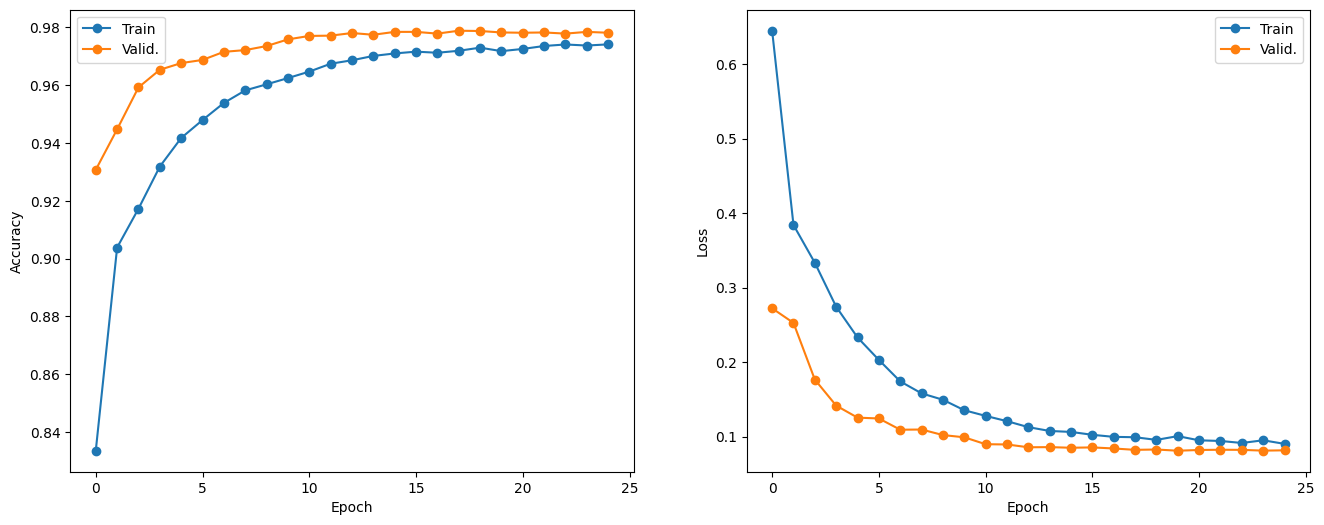

In [23]:
if history is not None:
    fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
    axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
    axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
    axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
    axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend( loc='best' )
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend( loc='best' )

In [24]:
model_final.evaluate( X_train, y_train ) # without dropout

1563/1563 [==============================] - 4s 2ms/step - loss: 0.0344 - accuracy: 0.9898


[0.03436236456036568, 0.9897800087928772]

In [25]:
model_final.evaluate( X_valid, y_valid )

313/313 [==============================] - 1s 3ms/step - loss: 0.0811 - accuracy: 0.9782


[0.08106036484241486, 0.9782000184059143]

### Teste

In [26]:
model_final.evaluate( X_test, y_test )

313/313 [==============================] - 1s 3ms/step - loss: 0.0973 - accuracy: 0.9750


[0.0973227247595787, 0.9750000238418579]

In [27]:
y_test_proba = model_final.predict( X_test )
print ( y_test_proba )
y_test_pred = np.argmax( y_test_proba, axis=-1 )
print ( y_test_pred )

313/313 [==============================] - 1s 2ms/step
[[9.9997687e-01 4.8940779e-11 3.8128431e-07 ... 1.3284367e-06
  3.2491499e-07 3.5898215e-06]
 [9.9999297e-01 5.6930745e-12 7.8146499e-08 ... 3.9319025e-07
  9.7257661e-08 1.4822381e-06]
 [9.9999714e-01 6.5020786e-13 1.4308839e-08 ... 2.3941791e-07
  3.0192080e-08 6.5376514e-07]
 ...
 [4.2389718e-07 3.3077008e-06 9.3326730e-07 ... 4.1267162e-04
  1.9035475e-04 9.9892837e-01]
 [5.6265947e-08 7.9568628e-07 2.0756261e-07 ... 1.2200203e-04
  6.8436158e-05 9.9958223e-01]
 [2.5313309e-08 2.9391310e-07 1.1774976e-07 ... 7.2742529e-05
  1.6600012e-05 9.9970078e-01]]
[0 0 0 ... 9 9 9]


In [28]:
accuracy = np.sum( y_test_pred == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.975


250
0: 10
1: 9
2: 26
3: 21
4: 30
5: 34
6: 17
7: 29
8: 37
9: 37


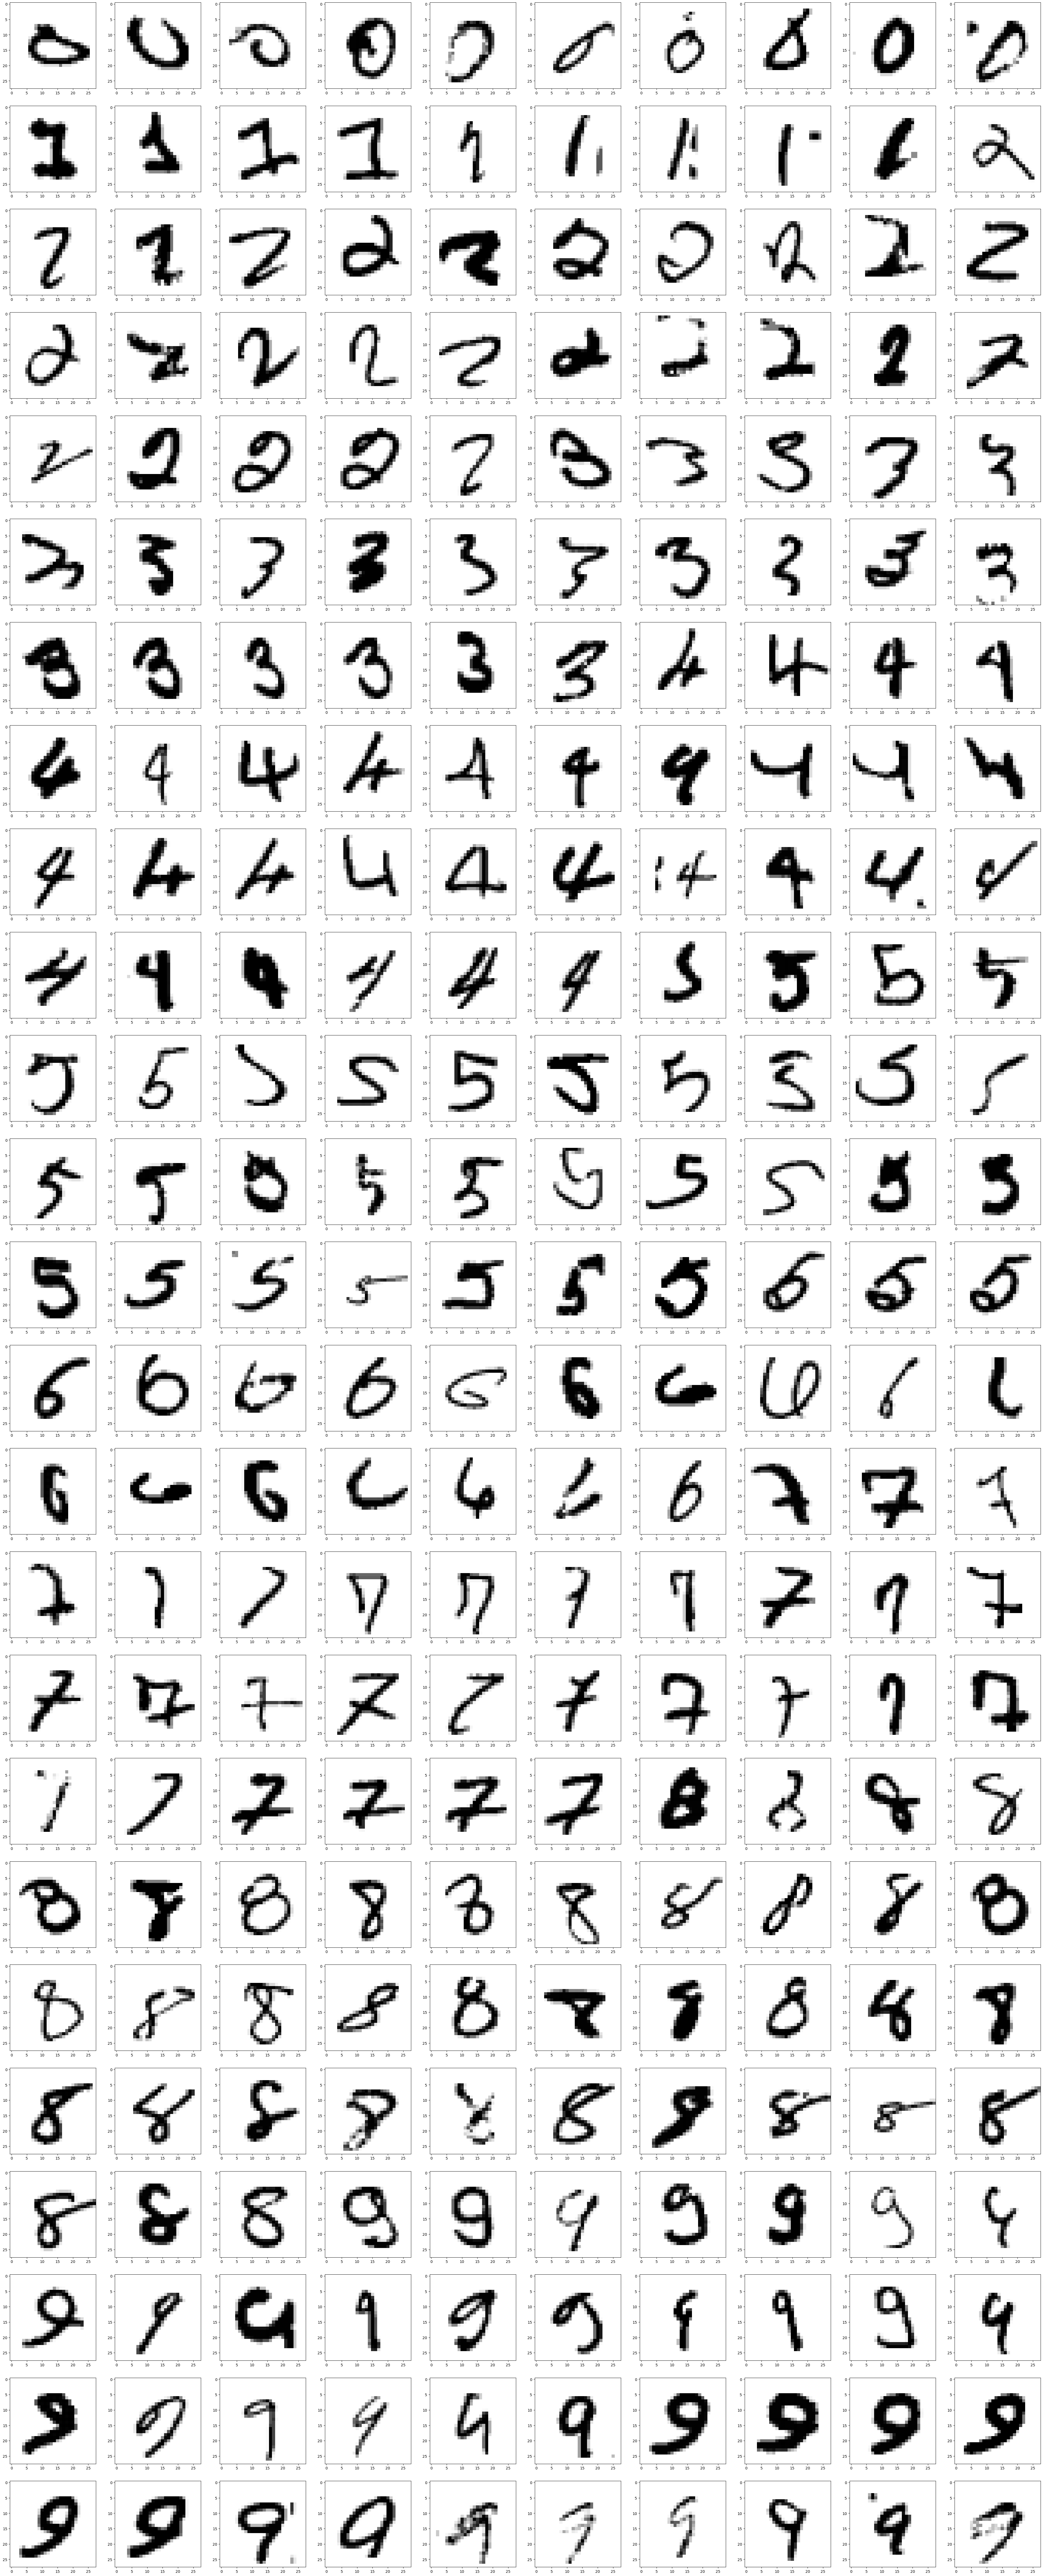

In [29]:
def plot_digits( X, n, start = 0 ):
    n_per_row_ = 10
    n_rows_ = int( ( n / n_per_row_  ) if ( n % n_per_row_ ) == 0 else ( ( n // n_per_row_ ) + 1 ) )
    size_ = 5
    fig_, axes_ = plt.subplots( n_rows_, n_per_row_, figsize=( n_per_row_ * size_ , n_rows_ * size_ ) )
    idx_row_, idx_col_ = 0, 0
    for idx__ in range( n ):
        if idx__ >= len( X ): break

        ax_ = axes_[ idx_row_, idx_col_ ]
        ax_.imshow( X[ start+idx__ ].reshape(28,28), cmap='binary' )
        idx_col_ += 1
        if idx_col_ % n_per_row_ == 0:
            idx_row_ += 1
            idx_col_  = 0

msk_error_ = y_test_pred != y_test
print ( np.sum( msk_error_ ) )
for label_ in range( 10 ):
    msk__ = msk_error_ & ( y_test == label_ )
    print ( "{}: {}".format( label_, np.sum( msk__ ) ) )

plot_digits( X_test_raw[ msk_error_ ], 250 )